# Baseline "predictions" for blind test data

## Introduction

In this notebook, we will compute some baseline "predictions" to establish reference points for future stages of the project. These baselines will serve as benchmarks to assess the effectiveness of more advanced machine learning models implemented in later phases.

#### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import missingno as msno

In [2]:
# Instruction to show all rows and columns when printing dataframes 
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", None)

#### Loading necessary data:

In [22]:
blind_test_df = pd.read_csv('blind_test.csv')

## Computation of different baseline "predictions" to beat

##### Función para calcular SMAPE

In [8]:
def smape(a, f):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between two arrays.

    SMAPE is a measure of accuracy for continuous variables, expressed as a percentage.

    Parameters:
    a (np.array): Array of actual values.
    f (np.array): Array of forecasted values.

    Returns:
    float: SMAPE value as a percentage.
    """
    return 100 * np.mean(2 * np.abs(a - f) / (np.abs(a) + np.abs(f)))


def calculate_smape(df1, df2):
    """
    Calculate SMAPE for each row of two DataFrames.

    This function computes the SMAPE between corresponding rows of two DataFrames, 
    ignoring NaN values in the comparison.

    Parameters:
    df1 (pd.DataFrame): DataFrame containing actual values.
    df2 (pd.DataFrame): DataFrame containing forecasted values.

    Returns:
    list: A list containing the SMAPE value for each row comparison.
    """
    
    smape_list = []

    # Convert both DataFrames to float type to ensure numerical operations
    df1 = df1.astype(float)
    df2 = df2.astype(float)
    
    # Iterate over each row of the DataFrames
    for i in range(df1.shape[0]):
        row1 = df1.iloc[i].values
        row2 = df2.iloc[i].values
        
        # Create a mask to filter out NaN values from both rows
        mask = ~np.isnan(row1) & ~np.isnan(row2)
        filtered_row1 = row1[mask]
        filtered_row2 = row2[mask]
        
        # Calculate SMAPE only if there are non-NaN values in both rows
        if len(filtered_row1) > 0:
            smape_value = smape(filtered_row1, filtered_row2)
            smape_list.append(smape_value)
    
    return smape_list

### Last Observed Value

This prediction method uses the last observed value (lag_1) to forecast all future steps. It assumes that the most recent known value remains constant throughout the forecast horizon.

In [27]:
past_window = 50
future_window = 26

# Create column names for past observations (lags) and future steps
past_columns = [f'lag_{i}' for i in range(past_window, 0, -1)]
future_columns = [f'step_{i}' for i in range(1, future_window + 1)]

# Copy the future columns from the 'blind_test_df' to create baseline predictions
baseline_pred_lag1 = blind_test_df[future_columns].copy()

# Set each future step prediction equal to the most recent past observation ('lag_1')
for col in baseline_pred_lag1:
    baseline_pred_lag1[col] = blind_test_df["lag_1"]

# Reset the index of the DataFrame
baseline_pred_lag1 = baseline_pred_lag1.reset_index(drop = True)

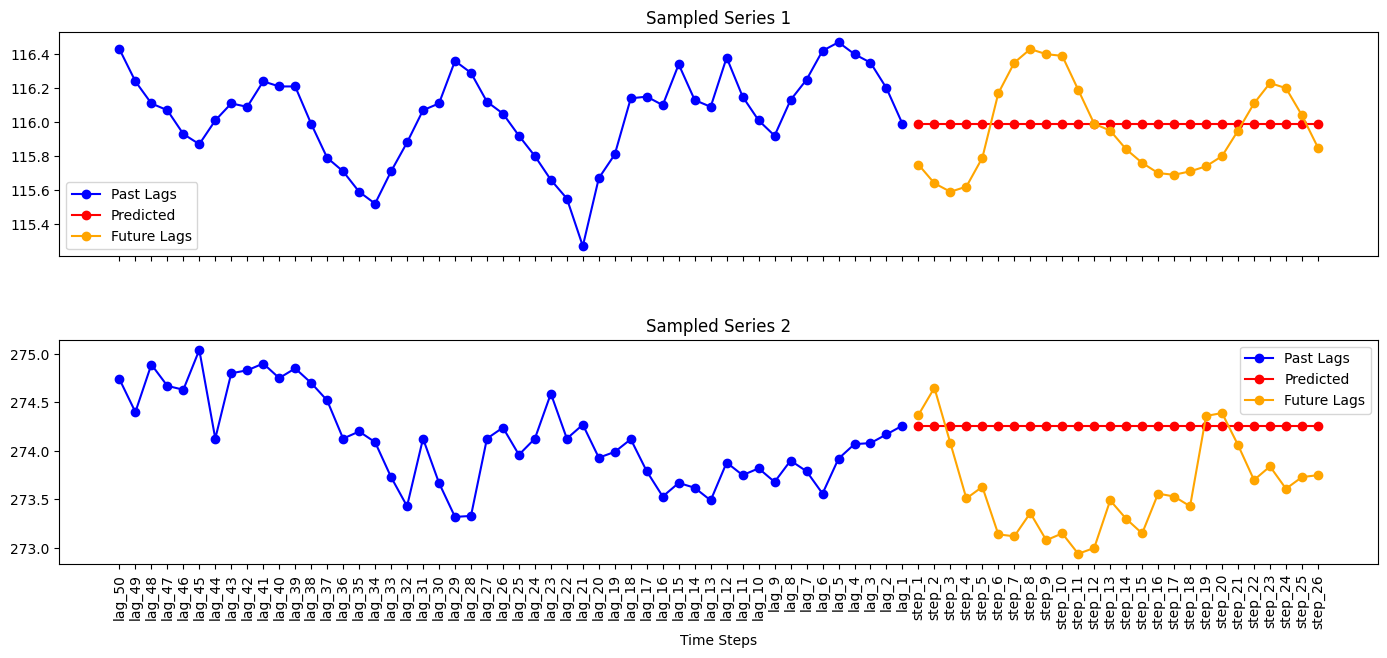

In [28]:
sampled_data = baseline_pred_lag1.iloc[:2,]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), sharex=True)
fig.tight_layout(pad=5.0)

# Plot the example time series
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    axes[i].plot(past_columns, blind_test_df[past_columns].iloc[idx], color='blue', marker='o', label='Past Lags')
    axes[i].plot(future_columns, row[future_columns], color='red', marker='o', label='Predicted')
    axes[i].plot(future_columns, blind_test_df[future_columns].iloc[idx], color='orange', marker='o', label='Future Lags')
    axes[i].set_title(f'Sampled Series {i+1}')
    axes[i].legend()

plt.xlabel('Time Steps')
plt.xticks(rotation = 90)
plt.show()


In [29]:
# Calculate SMAPE on blind test data
smape_results = calculate_smape(blind_test_df[future_columns], baseline_pred_lag1)

# Calculate and show the mean, sd and quartiles of the blind test SMAPE
mean_smape = np.mean(smape_results)
sd_smape = np.std(smape_results)
quartiles_smape = np.percentile(smape_results, [25, 50, 75])

print("Mean SMAPE: {}".format(mean_smape))
print("Standard Deviation SMAPE: {}".format(sd_smape))
print("\n25th Percentile (Q1): {}".format(quartiles_smape[0]))
print("50th Percentile (Median): {}".format(quartiles_smape[1]))
print("75th Percentile (Q3): {}".format(quartiles_smape[2]))

Mean SMAPE: 0.17251548901057454
Standard Deviation SMAPE: 0.16425545833099

25th Percentile (Q1): 0.07021046295158165
50th Percentile (Median): 0.12440059251621897
75th Percentile (Q3): 0.21821792559861158


### Average of last 4 years

This prediction method uses the average of the past 50 lags (approximately the mean of the last 4 years) to forecast all future steps. It assumes that future values will resemble the long-term historical average.

In [30]:
# Copy the future columns from the 'blind_test_df' to create baseline predictions
baseline_pred_mean_past = blind_test_df[future_columns].copy()

# Set each future step prediction equal to the mean of the past 50 lags
for col in baseline_pred_mean_past:
    baseline_pred_mean_past[col] = np.mean(blind_test_df[past_columns], axis=1)

# Reset the index of the DataFrame
baseline_pred_mean_past = baseline_pred_mean_past.reset_index(drop=True)

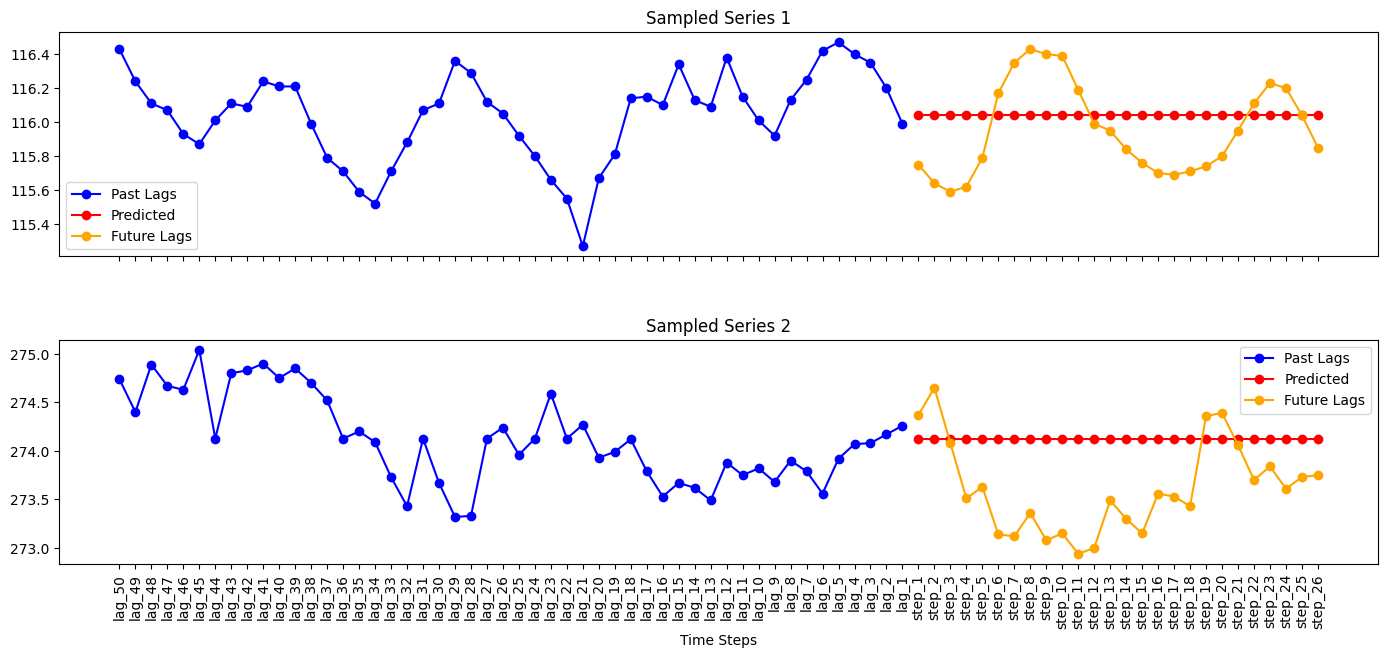

In [31]:
sampled_data = baseline_pred_mean_past.iloc[:2,]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), sharex=True)
fig.tight_layout(pad=5.0)

# Plot the example time series
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    axes[i].plot(past_columns, blind_test_df[past_columns].iloc[idx], color='blue', marker='o', label='Past Lags')
    axes[i].plot(future_columns, row[future_columns], color='red', marker='o', label='Predicted')
    axes[i].plot(future_columns, blind_test_df[future_columns].iloc[idx], color='orange', marker='o', label='Future Lags')
    axes[i].set_title(f'Sampled Series {i+1}')
    axes[i].legend()

plt.xlabel('Time Steps')
plt.xticks(rotation = 90)
plt.show()


In [32]:
# Calculate SMAPE on blind test data
smape_results = calculate_smape(blind_test_df[future_columns], baseline_pred_mean_past)

# Calculate and show the mean, sd and quartiles of the blind test SMAPE
mean_smape = np.mean(smape_results)
sd_smape = np.std(smape_results)
quartiles_smape = np.percentile(smape_results, [25, 50, 75])

print("Mean SMAPE: {}".format(mean_smape))
print("Standard Deviation SMAPE: {}".format(sd_smape))
print("\n25th Percentile (Q1): {}".format(quartiles_smape[0]))
print("50th Percentile (Median): {}".format(quartiles_smape[1]))
print("75th Percentile (Q3): {}".format(quartiles_smape[2]))

Mean SMAPE: 0.16513315478821622
Standard Deviation SMAPE: 0.1613844540619797

25th Percentile (Q1): 0.06607094050425608
50th Percentile (Median): 0.11736145698798311
75th Percentile (Q3): 0.21371642674203478


### Value 2 years ago

This prediction method uses the value from lag_24 (2 years ago) to forecast future steps. It assumes that the observation from 24 periods ago is a good indicator for all future values.

In [41]:
past_window = 50
future_window = 26

# Copy the last 25 past lags (including lag_24) from the dataset
baseline_pred_lag24 = blind_test_df[blind_test_df[past_columns].columns[-25:]].copy()

# Add a temporary column to represent lag_24 for future predictions
baseline_pred_lag24['temp'] = baseline_pred_lag24[baseline_pred_lag24.columns[-1]]

# Rename columns to match the future steps format
baseline_pred_lag24.columns = blind_test_df[future_columns].columns

# Reset the index of the DataFrame
baseline_pred_lag24 = baseline_pred_lag24.reset_index(drop=True)

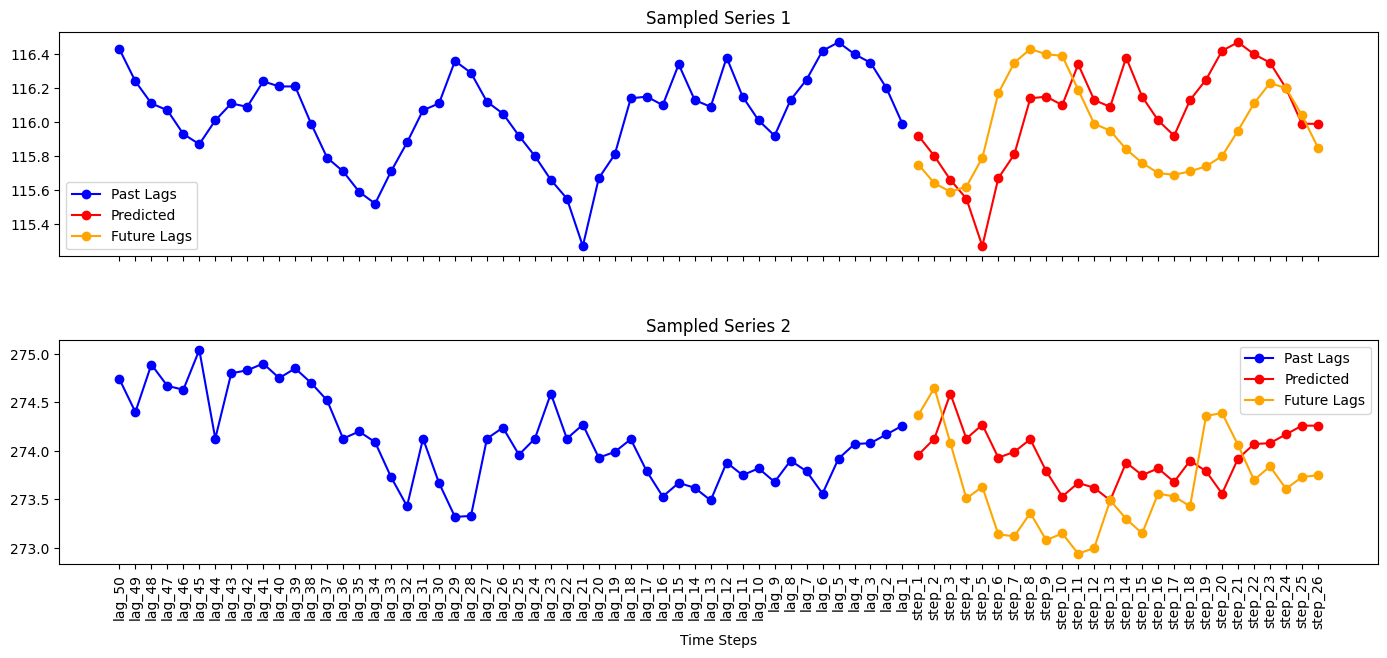

In [42]:
sampled_data = baseline_pred_lag24.iloc[:2,]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), sharex=True)
fig.tight_layout(pad=5.0)

# Plot the example time series
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    axes[i].plot(past_columns, blind_test_df[past_columns].iloc[idx], color='blue', marker='o', label='Past Lags')
    axes[i].plot(future_columns, row[future_columns], color='red', marker='o', label='Predicted')
    axes[i].plot(future_columns, blind_test_df[future_columns].iloc[idx], color='orange', marker='o', label='Future Lags')
    axes[i].set_title(f'Sampled Series {i+1}')
    axes[i].legend()

plt.xlabel('Time Steps')
plt.xticks(rotation = 90)
plt.show()


In [43]:
# Calculate SMAPE on blind test data
smape_results = calculate_smape(blind_test_df[future_columns], baseline_pred_lag24)

# Calculate and show the mean, sd and quartiles of the blind test SMAPE
mean_smape = np.mean(smape_results)
sd_smape = np.std(smape_results)
quartiles_smape = np.percentile(smape_results, [25, 50, 75])

print("Mean SMAPE: {}".format(mean_smape))
print("Standard Deviation SMAPE: {}".format(sd_smape))
print("\n25th Percentile (Q1): {}".format(quartiles_smape[0]))
print("50th Percentile (Median): {}".format(quartiles_smape[1]))
print("75th Percentile (Q3): {}".format(quartiles_smape[2]))

Mean SMAPE: 0.18591034727332817
Standard Deviation SMAPE: 0.17186822942661217

25th Percentile (Q1): 0.07588506826809684
50th Percentile (Median): 0.13862486206018795
75th Percentile (Q3): 0.240099479867844


### Average of Lags 24, 36, 48

This prediction method calculates the average of the lags from 48, 36, and 24 periods ago (2,3,4 years) for each observation. It uses these averages to predict future steps, assuming that the combined information from these specific lags provides a meaningful forecast.

In [36]:
# Create empty lists to store the names of the new columns and the corresponding data
new_columns = []
data = []

# Iterate over the indices to create groups of columns
for i in range(49, 24, -1):
    # Define the group of columns to average (lag_i, lag_i-12, lag_i-24)
    columns_to_average = [f'lag_{i}', f'lag_{i-12}', f'lag_{i-24}']
    
    # Ensure that all columns exist in the DataFrame before averaging
    columns_to_average = [col for col in columns_to_average if col in blind_test_df[past_columns].columns]
    
    # Calculate the mean of the selected columns
    mean_values = np.mean(blind_test_df[past_columns][columns_to_average], axis=1)
    
    # Store the name of the new column and its data
    new_column_name = f'average_{i}'
    new_columns.append(new_column_name)
    data.append(mean_values)

# Create a new DataFrame with the calculated averages
new_df = pd.DataFrame({name: data_point for name, data_point in zip(new_columns, data)})

# Create a baseline prediction based on the averaged lags (lags 48, 36, 24)
baseline_pred_mean_lags_48_36_24 = new_df

# Add a temporary column using the last calculated average value
baseline_pred_mean_lags_48_36_24['temp'] = baseline_pred_mean_lags_48_36_24[baseline_pred_mean_lags_48_36_24.columns[-1]]

# Rename columns to match the future steps format
baseline_pred_mean_lags_48_36_24.columns = future_columns

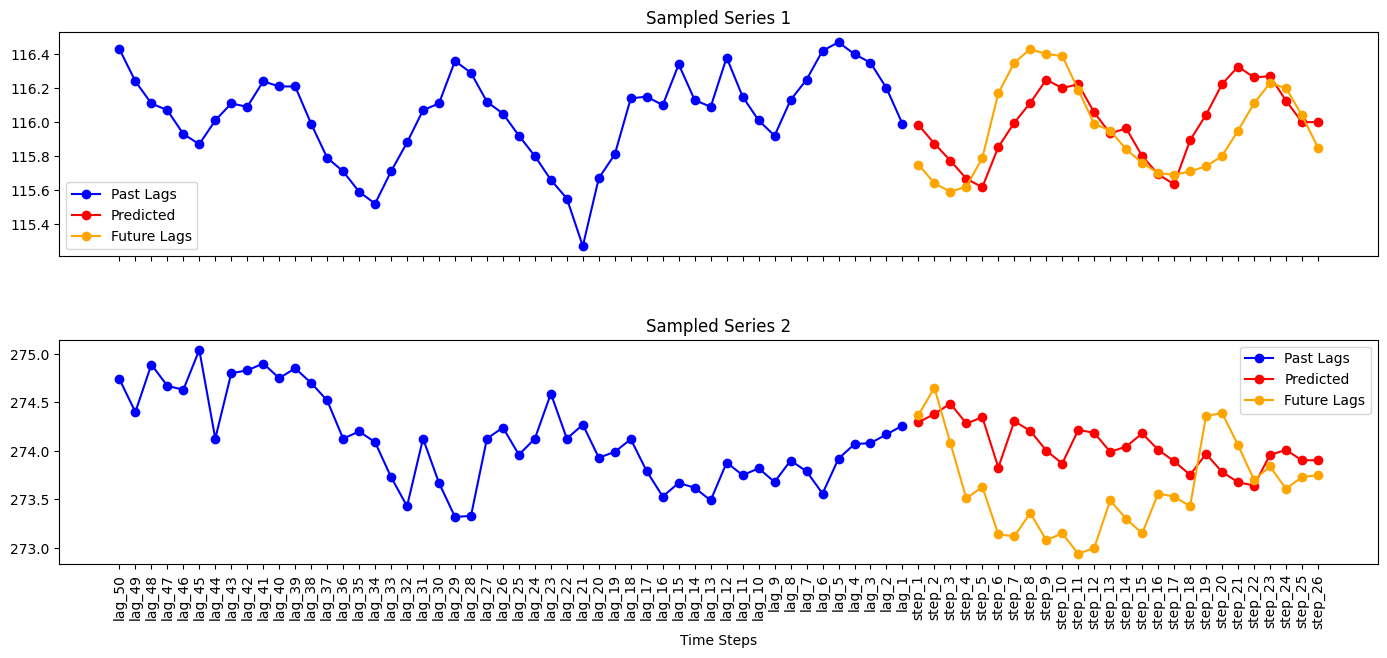

In [37]:
sampled_data = baseline_pred_mean_lags_48_36_24.iloc[:2,]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), sharex=True)
fig.tight_layout(pad=5.0)

# Plot the example time series
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    axes[i].plot(past_columns, blind_test_df[past_columns].iloc[idx], color='blue', marker='o', label='Past Lags')
    axes[i].plot(future_columns, row[future_columns], color='red', marker='o', label='Predicted')
    axes[i].plot(future_columns, blind_test_df[future_columns].iloc[idx], color='orange', marker='o', label='Future Lags')
    axes[i].set_title(f'Sampled Series {i+1}')
    axes[i].legend()

plt.xlabel('Time Steps')
plt.xticks(rotation = 90)
plt.show()

In [38]:
# Calculate SMAPE on blind test data
smape_results = calculate_smape(blind_test_df[future_columns], baseline_pred_mean_lags_48_36_24)

# Calculate and show the mean, sd and quartiles of the blind test SMAPE
mean_smape = np.mean(smape_results)
sd_smape = np.std(smape_results)
quartiles_smape = np.percentile(smape_results, [25, 50, 75])

print("Mean SMAPE: {}".format(mean_smape))
print("Standard Deviation SMAPE: {}".format(sd_smape))
print("\n25th Percentile (Q1): {}".format(quartiles_smape[0]))
print("50th Percentile (Median): {}".format(quartiles_smape[1]))
print("75th Percentile (Q3): {}".format(quartiles_smape[2]))

Mean SMAPE: 0.17000712147263072
Standard Deviation SMAPE: 0.16562992943657198

25th Percentile (Q1): 0.06742873052719169
50th Percentile (Median): 0.12190601265295556
75th Percentile (Q3): 0.21892263433010045
